# Importing the Packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import glob
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
import random
import sys
import torchvision.transforms as transforms
from torchvision import datasets

# Reading the images

In [20]:
tumor = []
path = './Dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
    tumor.append(img)

In [21]:
len(tumor)

1500

In [22]:
healthy = []
path = './Dataset/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
    healthy.append(img)

In [23]:
len(healthy)

1500

In [24]:
tumor = np.array(tumor, dtype=np.float32)
healthy = np.array(healthy, dtype=np.float32)
tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

In [25]:
tumor.shape

(1500, 3, 128, 128)

In [26]:
healthy.shape

(1500, 3, 128, 128)

In [27]:
images = np.concatenate((healthy, tumor), axis=0)
labels = np.concatenate((tumor_label, healthy_label), axis=0)

In [28]:
images.shape

(3000, 3, 128, 128)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0, shuffle=True, stratify=labels)

# Creating Functions for Data Augmentations

In [30]:
# Performing Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),  # Rotate up to ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness & contrast shift
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),  # Shift, scale & rotate
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

In [31]:
#Test Set (No Augmentation, Only Normalization)
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

## Creating MRI Custom Dataset Class

In [32]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __add__(self, other):
        return ConcatDataset([self, other])

In [33]:
class MRI(Dataset):
    def __init__(self, feature_matrix, target_label_array, mode='train'):
        self.images = feature_matrix
        self.labels = target_label_array
        self.mode = mode  # 'train' or 'val'
        self.transform = train_transforms if mode == 'train' else val_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        image, label = self.images[index], self.labels[index]
    
        # Ensure image is a tensor
        if isinstance(image, torch.Tensor):
            image = image.numpy()
    
        # Ensure correct shape (C, H, W) → (H, W, C)
        image = np.transpose(image, (1, 2, 0))
    
        # Convert to uint8 (avoid changing shape incorrectly)
        image = (image * 255).astype(np.uint8)
    
        # Convert to PIL Image **individually**
        image = transforms.ToPILImage()(image)
    
        # Apply transformations
        image = self.transform(image)
    
        return {'image': image, 'label': label}




# Creating a Dataloader

In [34]:
mri_dataset = MRI(feature_matrix=X_train, target_label_array=y_train, mode='train')

In [35]:
dataloader = DataLoader(dataset = mri_dataset, batch_size = 10, shuffle = True)

# Creating a model

In [47]:
import torch.nn as nn

class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Drop 50% of neurons
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))  # Dropout before FC layer
        x = self.fc2(x)
        return self.sigmoid(x)


# Training the Model

In [48]:
mri_dataset_train = MRI(feature_matrix=X_train, target_label_array=y_train, mode='train')
mri_dataset_test = MRI(feature_matrix=X_test, target_label_array=y_test, mode='test')

In [49]:
train_dataloader = DataLoader(mri_dataset_train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset_test, batch_size=32, shuffle=False)

In [50]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN().to(DEVICE)

In [51]:
LEARNING_RATE = 1e-3
EPOCH = 300
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
dataloader = DataLoader(mri_dataset_train, batch_size=32, shuffle=True)
model.train()

BrainTumorCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [52]:
# keeping track of epoch losses
epoch_train_loss = []
epoch_test_loss = []
accuracy_train_epoch = []
accuracy_test_epoch = []

In [53]:
for epoch in range(EPOCH):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset_train.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(DEVICE)
        label = D['label'].to(DEVICE)
        
        y_hat = model(data)
        y_hat_binary = (y_hat.detach().cpu().numpy() >= 0.5).astype(int)  # threshold at 0.5
        
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        accuracy_train = accuracy_score(y_pred=y_hat_binary, y_true=label.cpu().numpy()) 
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    accuracy_train_epoch.append(accuracy_train)
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    test_losses = []
    model.eval()
    
    mri_dataset_test.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(DEVICE)
            label = D['label'].to(DEVICE)
            
            y_hat = model(data)
            y_hat_binary = (y_hat.detach().cpu().numpy() >= 0.5).astype(int) 
            
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            test_losses.append(loss.item())
            accuracy_test = accuracy_score(y_pred=y_hat_binary, y_true=label.cpu().numpy()) 
    accuracy_test_epoch.append(accuracy_test)
    epoch_test_loss.append(np.mean(test_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(test_losses)))

Train Epoch: 10	Train Loss: 0.334633	Val Loss: 0.286838
Train Epoch: 20	Train Loss: 0.197334	Val Loss: 0.170583
Train Epoch: 30	Train Loss: 0.116159	Val Loss: 0.158768
Train Epoch: 40	Train Loss: 0.111703	Val Loss: 0.173329
Train Epoch: 50	Train Loss: 0.069762	Val Loss: 0.356668
Train Epoch: 60	Train Loss: 0.054887	Val Loss: 0.471003
Train Epoch: 70	Train Loss: 0.055474	Val Loss: 0.447538
Train Epoch: 80	Train Loss: 0.046446	Val Loss: 0.621376
Train Epoch: 90	Train Loss: 0.036805	Val Loss: 0.638224
Train Epoch: 100	Train Loss: 0.041594	Val Loss: 0.644786
Train Epoch: 110	Train Loss: 0.025177	Val Loss: 0.791067
Train Epoch: 120	Train Loss: 0.032261	Val Loss: 0.789120
Train Epoch: 130	Train Loss: 0.040732	Val Loss: 0.605380
Train Epoch: 140	Train Loss: 0.017743	Val Loss: 0.623032
Train Epoch: 150	Train Loss: 0.035372	Val Loss: 0.845206
Train Epoch: 160	Train Loss: 0.047035	Val Loss: 0.636156
Train Epoch: 170	Train Loss: 0.016307	Val Loss: 0.638064
Train Epoch: 180	Train Loss: 0.018550	Va

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

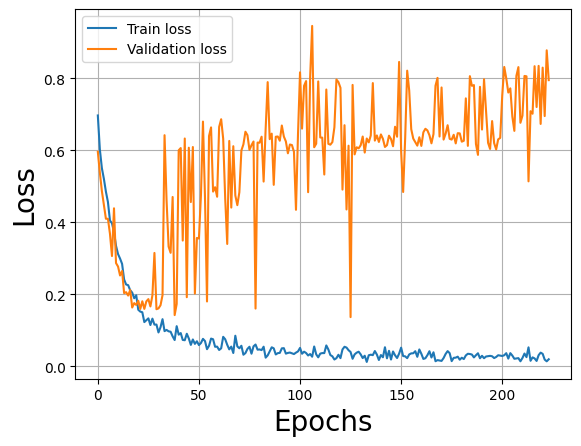

In [55]:
# plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, label='Train loss')
plt.plot(epoch_test_loss, label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)